<a href="https://colab.research.google.com/github/LukyLuke92/freeCodeCamp-files-LR/blob/main/MachineLearningWithPython/CatAndDogImageClassifier/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 25 # Increasing to 25 seemed to yield higher accuracy
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-06-16 16:08:21--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M  48.3MB/s    in 1.4s    

2024-06-16 16:08:23 (48.3 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                           batch_size = batch_size,
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                              batch_size = batch_size,
                                                              class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(os.path.dirname(test_dir),
                                                         target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                         batch_size = batch_size,
                                                         class_mode=None,
                                                         classes=['test'],
                                                         shuffle=False)
'''
# Tried using tf.keras.preprocessing.image_dataset_from_directory since ImageDataGenerator is deprecated
# Because image_dataset_from_directory does not have a 'rescale' option, we will need to add a rescaling
#  layer to the model (I think)
# This results in issues with plotting, since next(iter(*_data_gen)) returns a tuple, which cannot easily be scaled
#  down to [0,1], which is expected for floats - results in essentially all white images
train_data_gen = image_dataset_from_directory(train_dir,
                                              batch_size=batch_size,
                                              image_size=(IMG_HEIGHT,IMG_WIDTH),
                                              label_mode='binary')
val_data_gen = image_dataset_from_directory(validation_dir,
                                            batch_size=batch_size,
                                            image_size=(IMG_HEIGHT,IMG_WIDTH),
                                            label_mode='binary')
test_data_gen = image_dataset_from_directory(test_dir,
                                             batch_size=batch_size,
                                             image_size=(IMG_HEIGHT,IMG_WIDTH),
                                             label_mode=None,
                                             labels=None)
'''

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 50 files belonging to 1 classes.


In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()
### Suppressed plotting to clean up notebook output ###
#sample_training_images, _ = next(iter(train_data_gen))
#plotImages(sample_training_images[:5])

### Lines below plot the test images - troubleshooting ###
#test_images = next(test_data_gen)
#plotImages(test_images[:5])


In [ ]:
# 5
# Comment if using image_dataset_from_directory
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=20,
                                           brightness_range=[0.75,1.25],
                                           shear_range=20,
                                           horizontal_flip=True)

' Uncomment if using ImageDataGenerator\ntrain_image_generator = ImageDataGenerator(rescale=1./255,\n                                           rotation_range=20,\n                                           brightness_range=[0.75,1.25],\n                                           shear_range=20,\n                                           horizontal_flip=True)\n'

In [ ]:
# 6
# Comment if using image_dataset_from_directory
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

### Suppressed plotting to clean up notebook output ###
#augmented_images = [train_data_gen[0][0][0] for i in range(5)]
#plotImages(augmented_images)

" Uncomment if using ImageDataGenerator\ntrain_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,\n                                                     directory=train_dir,\n                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),\n                                                     class_mode='binary')\n"

In [ ]:
# 7
model = Sequential([
    '''
    # Code below does not use ImageDataGenerator, which is deprecated, and instead uses the
    #  output of image_dataset_from_directory, which returns a tf.data.Dataset
    # Instead of pre-processing using ImageDataGenerator, this adds layers at the start to the
    #  sequential model to augment the data - note that shear is missing, as it is not available
    #  in the tf.keras library
    tf.keras.layers.Rescaling(1./255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    tf.keras.layers.RandomRotation(0.05), # Note this is fraction of 2pi - 0.05 is ~20deg
    # tf.keras.layers.RandomBrightness(0.05), # Appears to break the model
    tf.keras.layers.RandomFlip('horizontal'),
    Conv2D(128,3,padding='same',strides=(1,1),activation='relu'),
    # Uncomment the below and comment the above 5 lines if using ImageDataGenerator
    '''
    Conv2D(128,3,padding='same',strides=(1,1),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128,3,activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128,3,activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128,3,activation='relu'),
    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(2,activation='softmax')
])

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation_11 (Random  (None, 150, 150, 3)       0         
 Rotation)                                                       
                                                                 
 random_brightness_10 (Rand  (None, 150, 150, 3)       0         
 omBrightness)                                                   
                                                                 
 random_flip_8 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 150, 150, 128)     3584      
                                                                 
 dropout_32 (Dropout)        (None, 150, 150, 128)   

In [ ]:
# 8
history = model.fit(x=train_data_gen,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=val_data_gen,
          )

Epoch 1/25
16/16 [==============================] - 11s 515ms/step - loss: 1.5127 - accuracy: 0.4840 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/25
16/16 [==============================] - 9s 499ms/step - loss: 0.6937 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/25
16/16 [==============================] - 9s 489ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/25
16/16 [==============================] - 9s 489ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/25
16/16 [==============================] - 10s 579ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/25
16/16 [==============================] - 9s 499ms/step - loss: 0.6935 - accuracy: 0.4930 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/25
16/16 [==============================] - 9s 509ms/step - loss: 0.6936 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoc

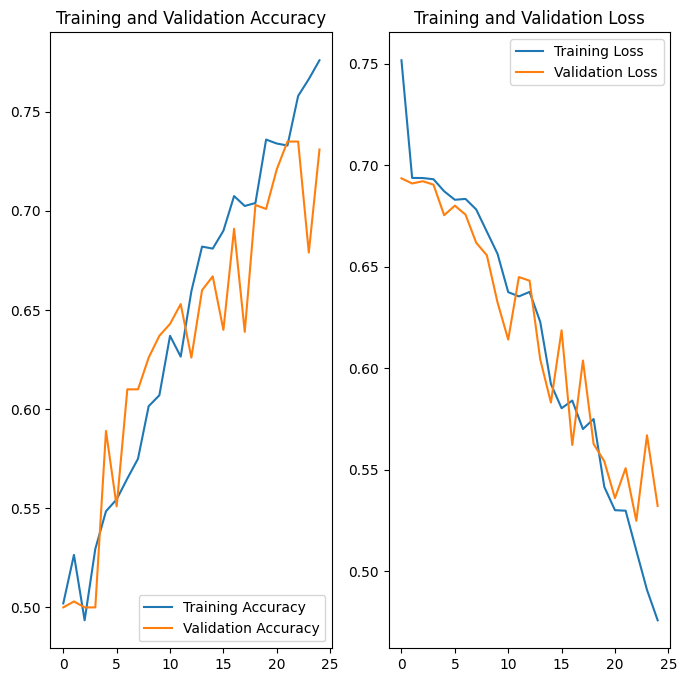

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 10
predictions = np.array(model.predict(test_data_gen,verbose=2))
probabilities = np.round(predictions[:,1])
print(probabilities)

1/1 - 0s - 121ms/epoch - 121ms/step
[0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 1.]


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 60.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
